In [44]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    py_file_location = "/content/drive/MyDrive/Tesis/Git/RedVolcanica"
    %cd "{py_file_location}" 
    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)  

False


In [45]:
import importlib

import RedFunciones.visualizacion as visualizacion
import RedFunciones.Generador as Generador
import RedFunciones.Discriminador as Discriminador
import RedFunciones.auxiliares as auxiliares
import RedFunciones.DataloaderVol as DataloaderVol
import RedFunciones.Checkpoint as Checkpoint

importlib.reload(auxiliares)
importlib.reload(Generador)
importlib.reload(Discriminador)
importlib.reload(DataloaderVol)
importlib.reload(Checkpoint)

<module 'RedFunciones.Checkpoint' from '/home/fgrijalva/RedVolcanica/RedVolcanica/RedFunciones/Checkpoint.py'>

In [46]:
import torch
from torch import nn
import torchaudio

from tqdm.auto import tqdm # Progress bar

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST #noned

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#torch.manual_seed(0) # Set for our testing purposes, please do not change!



In [47]:
import os
cwd = os.getcwd()
print(cwd)

/home/fgrijalva/RedVolcanica/RedVolcanica


criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate

device: the device type

In [48]:
mnist_shape = (1, 129, 33) #tamaño imagen
n_classes = 2 # numkero etiquetas
cuda0 = torch.device('cuda:0')
cpu = 'cpu'

device = torch.device(cuda0 if torch.cuda.is_available() else cpu)

criterion = nn.BCEWithLogitsLoss()
n_epochs = 2
z_dim = 64
display_step = 100
batch_size = 25
lr = 0.0002
nombre = 'master'
nombre_carga = 'master-2021-11-18.pt'
guardar = True
cargar = False
save_steep = 1

epoch_temp = -1
gen_loss_temp = torch.empty([])
disc_loss_temp = torch.empty([]) 

In [49]:
dir_nam = cwd + '/basedesglosada/'
json_nam = cwd + '/data.json'
h5_filename = cwd + '/baseh5/data2.h5'

myDataA = DataloaderVol.VolcanoDatasetH5(h5_filename)

dataloaderA = DataLoader(
    myDataA,
    batch_size=batch_size,
    shuffle=True)

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(dataloaderA)

print(mean)
print(std)

tensor([12.0745])
tensor([51.3877])


In [50]:
#cargar datos
dir_nam = cwd + '/basedesglosada/'
json_nam = cwd + '/data.json'
h5_filename = cwd + '/baseh5/data2.h5'

transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Normalize((12.0716,), (51.3133,)),
    #torchaudio.transforms.MelScale(sample_rate=50, n_stft=129)
])

myData = DataloaderVol.VolcanoDatasetH5(h5_filename, transform)

dataloader = DataLoader(
    myData,
    batch_size=batch_size,
    shuffle=True)

In [51]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

gen = gen.float()
disc = disc.float()
gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

In [52]:
if cargar:
    compelto = Checkpoint.DIRECTORY + nombre_carga
    checkpoint = torch.load(compelto)
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    epoch_temp = checkpoint['epoch']
    gen_loss_temp = checkpoint['gen_loss']
    disc_loss_temp = checkpoint['dis_loss']
    print('Modelo cargado')
    print('epoch: ' + str(epoch_temp))

Epoch: 0


  0%|          | 0/801 [00:00<?, ?it/s]

Red Funcionando
Step 100: Generator loss: 2.1455881732702253, discriminator loss: 0.252303176894784


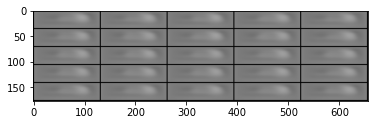

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


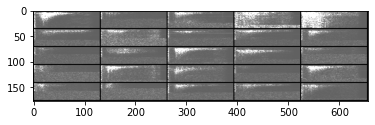

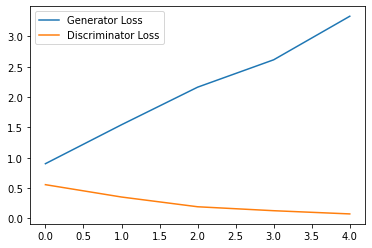

Step 200: Generator loss: 3.9278129363059997, discriminator loss: 0.04636522823944688


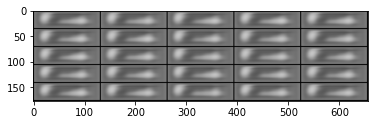

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


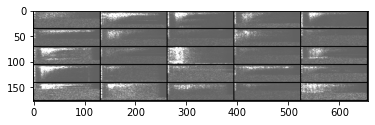

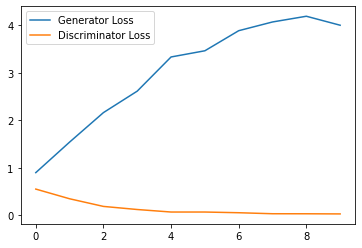

Step 300: Generator loss: 4.613028905391693, discriminator loss: 0.046546638919971885


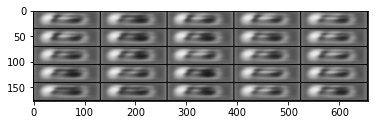

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


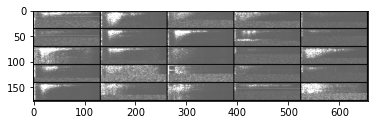

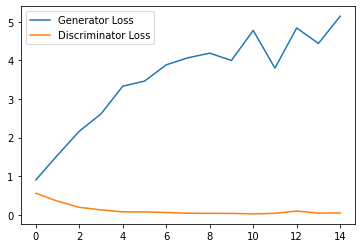

Step 400: Generator loss: 5.365738236904145, discriminator loss: 0.02993544212076813


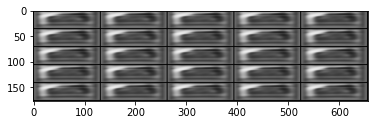

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


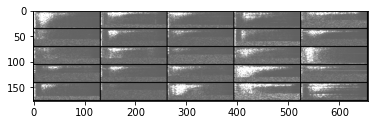

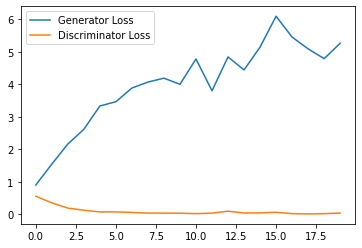

Step 500: Generator loss: 5.481726083755493, discriminator loss: 0.019933349955826997


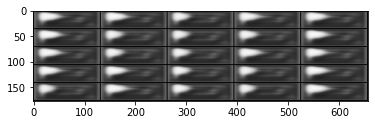

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


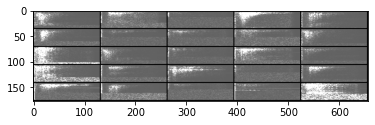

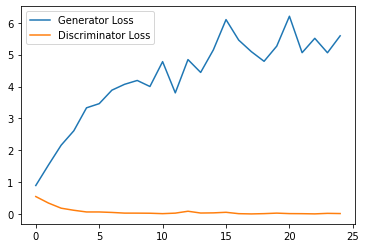

Step 600: Generator loss: 5.80651272058487, discriminator loss: 0.02739691184950061


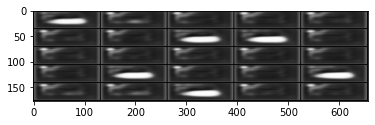

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


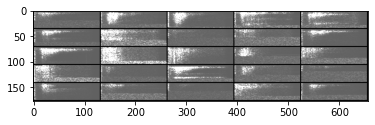

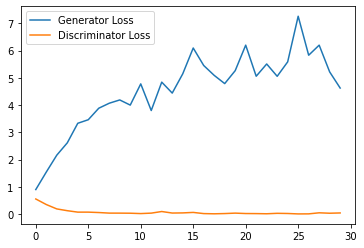

Step 700: Generator loss: 5.997628024816513, discriminator loss: 0.06180412129266188


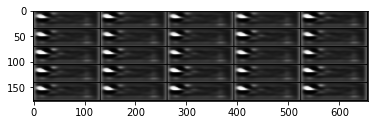

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


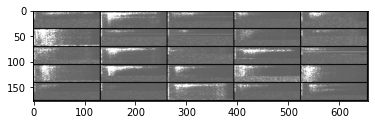

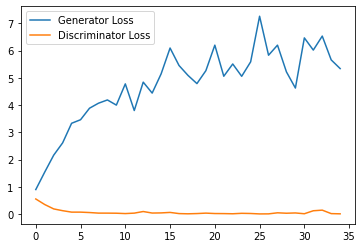

Step 800: Generator loss: 4.938769669532776, discriminator loss: 0.015165535470005124


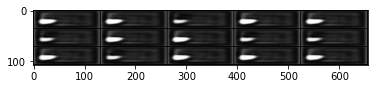

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


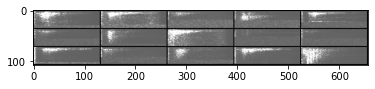

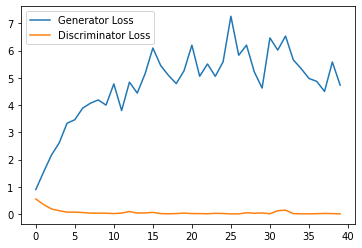

epoch guardada
Epoch: 1


  0%|          | 0/801 [00:00<?, ?it/s]

Step 900: Generator loss: 6.53330668926239, discriminator loss: 0.03577198968618177


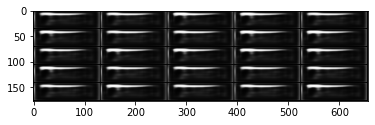

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


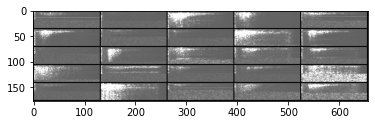

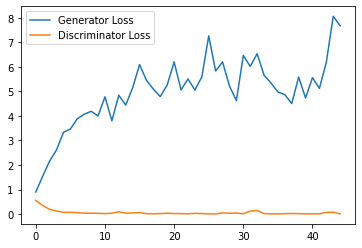

Step 1000: Generator loss: 5.804504368305206, discriminator loss: 0.021021413913695143


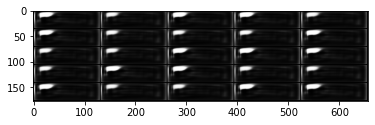

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


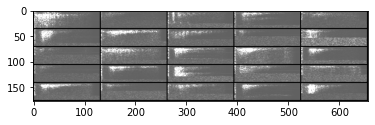

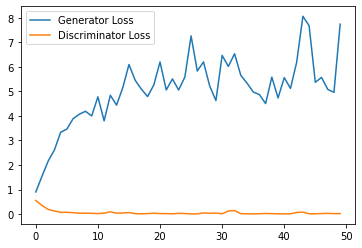

Step 1100: Generator loss: 6.488596396744251, discriminator loss: 0.07493733809911646


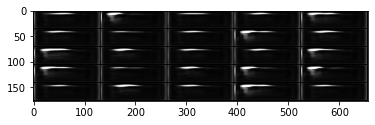

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


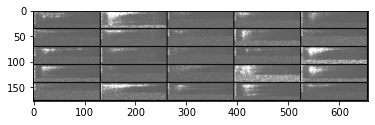

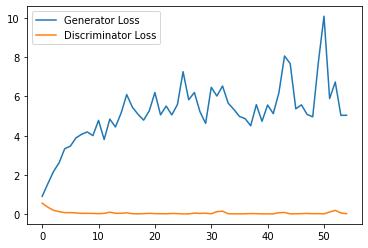

Step 1200: Generator loss: 5.433715879917145, discriminator loss: 0.03601768183056265


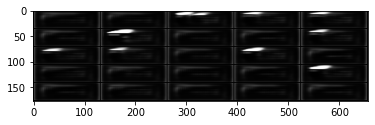

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


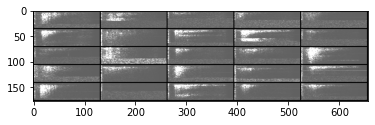

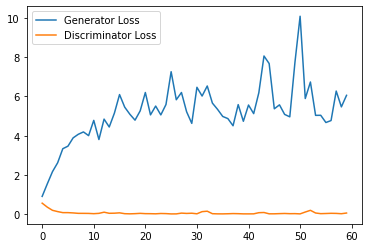

Step 1300: Generator loss: 5.839666674137115, discriminator loss: 0.016776415414642542


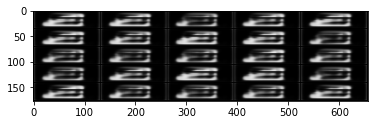

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


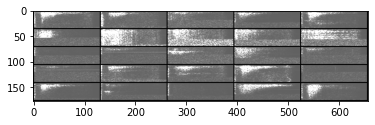

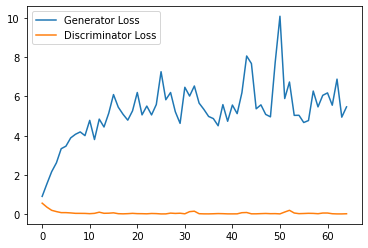

Step 1400: Generator loss: 6.21950743675232, discriminator loss: 0.0060335131047759205


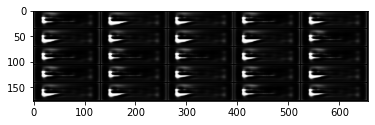

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


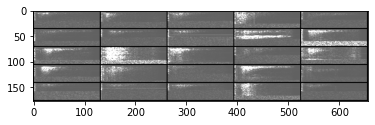

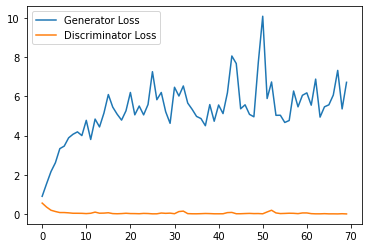

Step 1500: Generator loss: 6.281170680522918, discriminator loss: 0.006185202481574379


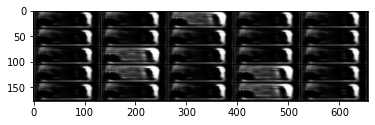

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


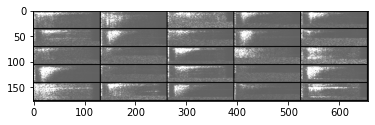

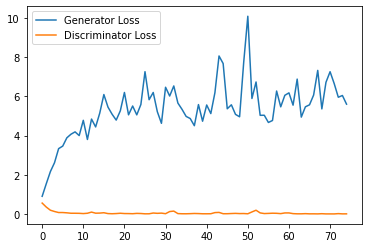

Step 1600: Generator loss: 6.0923208904266355, discriminator loss: 0.005171361966640689


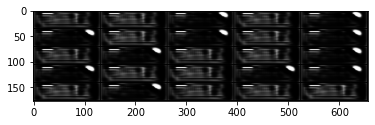

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


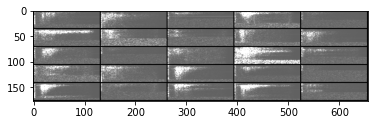

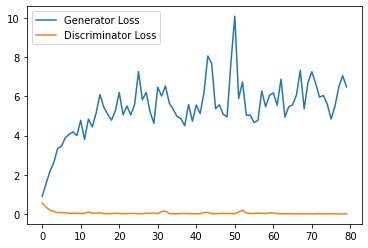

epoch guardada


In [53]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(epoch_temp + 1, n_epochs):
    print('Epoch: ' + str(epoch))
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels.float())#gen.forward(noise_and_labels) no usar

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = auxiliares.combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.float())
        disc_real_pred = disc(real_image_and_labels.float())       
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = auxiliares.combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            visualizacion.show_tensor_images(torch.transpose(fake, 2, 3), size=(1, 129, 33))
            visualizacion.show_tensor_images(torch.transpose(real, 2, 3), size=(1, 129, 33))
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Red Funcionando")
        cur_step += 1 
    if((guardar and epoch % save_steep == 0) or epoch == n_epochs - 1):
        Checkpoint.save_weighs(gen, disc, gen_opt, disc_opt, epoch, gen_loss, disc_loss, nombre)
        print('epoch guardada')                

In [ ]:
print(fake)

In [ ]:
print(gen)

In [ ]:
#gen.state_dict()

In [ ]:
from torchvision import models
from torchsummary import summary

summary(gen, (66,1,1))

summary(disc, (3,129,33))